In [ ]:
import os

setting up folders and paths

In [ ]:
customized_model_name = 'my_ssd_mobnet'
pretrained_model_name = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
prepared_train_model_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TFrecord_generating_script = 'generate_tfrecord.py'
label_map_name = 'label_map.pbtxt'

In [ ]:
paths = {
    'scripts_path' : os.path.join('Tensorflow', 'scripts'),
    'api_model_path' : os.path.join('Tensorflow', 'models'),
    'workspace_path' : os.path.join('Tensorflow', 'workspace'),
    'image_path': os.path.join('Tensorflow', 'workspace', 'images'),
    'train_path' : os.path.join('Tensorflow', 'workspace', 'images', 'train'),
    'test_path' : os.path.join('Tensorflow', 'workspace', 'images', 'test'),
    'model_path' : os.path.join('Tensorflow', 'workspace', 'models'),
    'pre_trained_model_path' : os.path.join('Tensorflow', 'workspace', 'pre-trained-models'),
    'checkpoint_path' : os.path.join('Tensorflow', 'workspace', 'models', customized_model_name),
    'output_path' : os.path.join('Tensorflow', 'workspace', 'models', customized_model_name, 'export'),
    'tfjs_path': os.path.join('Tensorflow', 'workspace','models',customized_model_name, 'tfjsexport'),
    'tflite_path' : os.path.join('Tensorflow', 'workspace','models',customized_model_name, 'tfliteexport'),
    'protoc_path' : os.path.join('Tensorflow', 'protoc'),
    'annotation_path' : os.path.join('Tensorflow','workspace','annotations')
}

In [ ]:
files = {
    'pipeline_config' : os.path.join('Tensorflow', 'workspace','models', customized_model_name, 'pipeline.config'),
    'tf_record_script' : os.path.join(paths['scripts_path'], TFrecord_generating_script),
    'label_map' : os.path.join(paths['annotation_path'], label_map_name)
}

In [ ]:
for eachPath in paths.values():
    if not os.path.exists(eachPath):
        !mkdir -p {eachPath}

In [ ]:
if not os.path.exists(os.path.join(paths['api_model_path'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['api_model_path']}

In [ ]:
!rm -r {paths['checkpoint_path']}

In [ ]:
!apt-get install protobuf-compiler
!cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 

In [ ]:
verification_script = os.path.join(paths['api_model_path'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')

!python {verification_script}

In [ ]:
!pip install tensorflow --upgrade

In [ ]:
!wget {prepared_train_model_url}
!mv {pretrained_model_name+'.tar.gz'} {paths['pre_trained_model_path']}
!cd {paths['pre_trained_model_path']} && tar -zxvf {pretrained_model_name + '.tar.gz'}

In [ ]:
import object_detection

In [ ]:
labels = [{
    'name' : 'usbDrive',
    'id' : 1
},
    {
        'name' : 'trimmer',
        'id' : 2
    }]

In [ ]:
with open(files['label_map'], 'w') as f:
    for each_label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(each_label['name']))
        f.write('\tid:{}\n'.format(each_label['id']))
        f.write('}\n')

In [ ]:
!wget https://raw.githubusercontent.com/shamindraparui/tensorflow-custom-object-detection/main/generate_tfrecord.py
!mv {TFrecord_generating_script} {paths['scripts_path']}

In [ ]:
!python {files['tf_record_script']} -x {os.path.join(paths['image_path'], 'train')} -l {files['label_map']} -o {os.path.join(paths['annotation_path'], 'train.record')}
!python {files['tf_record_script']} -x {os.path.join(paths['image_path'], 'test')} -l {files['label_map']} -o {os.path.join(paths['annotation_path'], 'test.record')} 

In [ ]:
!cp {os.path.join(paths['pre_trained_model_path'], pretrained_model_name, 'pipeline.config')} {os.path.join(paths['checkpoint_path'])}

In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['pipeline_config'])

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['pipeline_config'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)

In [ ]:
# this configuration only works with SSD
pipeline_config.model.faster_rcnn.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['pre_trained_model_path'], pretrained_model_name, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['label_map']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['annotation_path'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['label_map']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['annotation_path'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['pipeline_config'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)

In [ ]:
training_script = os.path.join(paths['api_model_path'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=3000".format(training_script, paths['checkpoint_path'],files['pipeline_config'])
print(command)

In [ ]:
!pip install opencv-python-headless==4.1.2.30

In [ ]:
!{command}

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(training_script, paths['checkpoint_path'],files['pipeline_config'], paths['checkpoint_path'])
print(command)

In [ ]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [ ]:
configs = config_util.get_configs_from_pipeline_file(files['pipeline_config'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)


ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
# ref : https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint


ckpt.restore(os.path.join(paths['checkpoint_path'], 'ckpt-4')).expect_partial()
# https://www.tensorflow.org/guide/checkpoint  --   https://stackoverflow.com/questions/33759623/how-to-save-restore-a-model-after-training


@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [ ]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(files['label_map'])

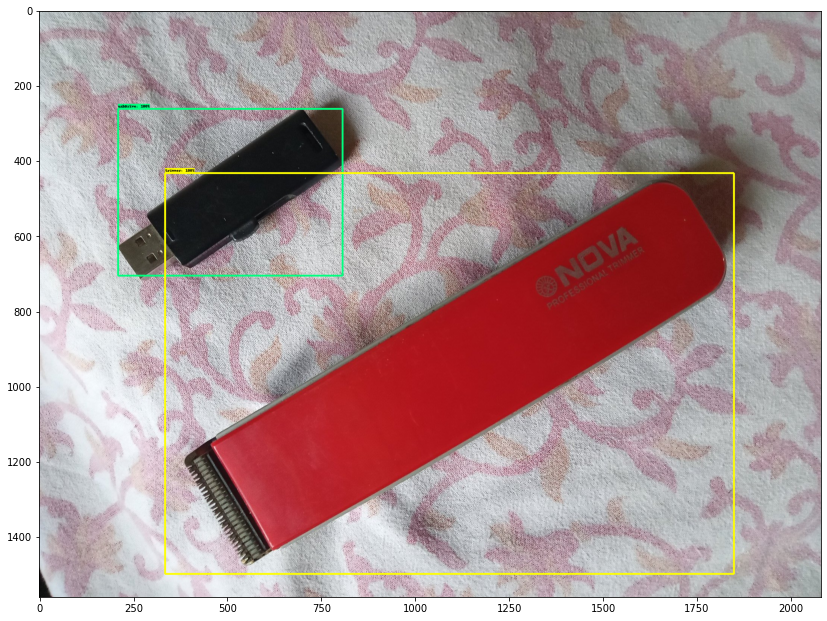

In [78]:
image_path = os.path.join(paths['image_path'], 'test', 'IMG20220127105640.jpg')
img = cv2.imread(image_path)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
# https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html


detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections


detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            line_thickness=5,
            agnostic_mode=False)
# https://towardsdatascience.com/model-agnostic-methods-for-interpreting-any-machine-learning-model-4f10787ef504

plt.figure(figsize=(14,12))
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()